In [1]:
# #To be used on cloud platforms

# ! python -c "import pykeen" || pip install pykeen
# ! python -c "import scprep" || pip install scprep

In [35]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, scanpy, networkx, scprep
import rpy2, rpy2.situation, anndata2ri


In [3]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab


# Prep

## Load scRNAseq data

We will have to use rpy to import the seurat object with the data. From there we already have code (from RNA Velo NBs) to extract metadata. Need to extract count matrices.

In [4]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ctest/

In [5]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython


In [6]:
%%R -i data_dir
library(tidyverse)
library(Seurat)

paste0(data_dir)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp



[1] "/gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab/data"


In [30]:
%%R -o dGenesSeq,dRnaSeq,dftest

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Get genes present in Seurat object
dGenesSeq = rownames(d_fibWT@assays$RNA@data)
#Convert seurat object to anndata
dRnaSeq = as.SingleCellExperiment(d_fibWT)
#Export PHATE coordinates
dftest = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))

rm(d_fibWT)

An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


Export list of genes detected in scRNA-seq dataset.
This will be used to subset the Knowledge Graph

In [8]:
len(list(dGenesSeq))

20867

In [31]:
print(dRnaSeq.var_names)
print(dRnaSeq.obs)
print(dRnaSeq.obsm)#No DimRed were ported over
dRnaSeq

Index(['Xkr4', 'Gm37363', 'Gm6123', 'Mrpl15', 'Gm37144', 'Lypla1', 'Gm37988',
       'Tcea1', 'Rgs20', 'Atp6v1h',
       ...
       'mt-Tg', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb',
       'mt-Tt', 'partDsRedE', 'pEGFP'],
      dtype='object', length=20867)
                         orig.ident  nCount_RNA  nFeature_RNA  mito_content  \
WT__AAACCCACAGCTTCCT-1  cocultWTFib     10761.0          3163      0.947867   
WT__AAACCCAGTTCGAGCC-1  cocultWTFib     15485.0          3811      1.233452   
WT__AAACGAAAGAAGGATG-1  cocultWTFib     16689.0          3775      1.270298   
WT__AAACGAAAGGAAAGGT-1  cocultWTFib      5756.0          2126      1.476720   
WT__AAACGAAAGTTAACGA-1  cocultWTFib     40330.0          4714      0.451277   
...                             ...         ...           ...           ...   
WT__TTTGGTTTCATTCTTG-1  cocultWTFib      9953.0          2555      0.351653   
WT__TTTGGTTTCCGTAGTA-1  cocultWTFib     15622.0          3810      1.389067   
WT__TTTGTT

AnnData object with n_obs × n_vars = 3698 × 20867
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    layers: 'logcounts'

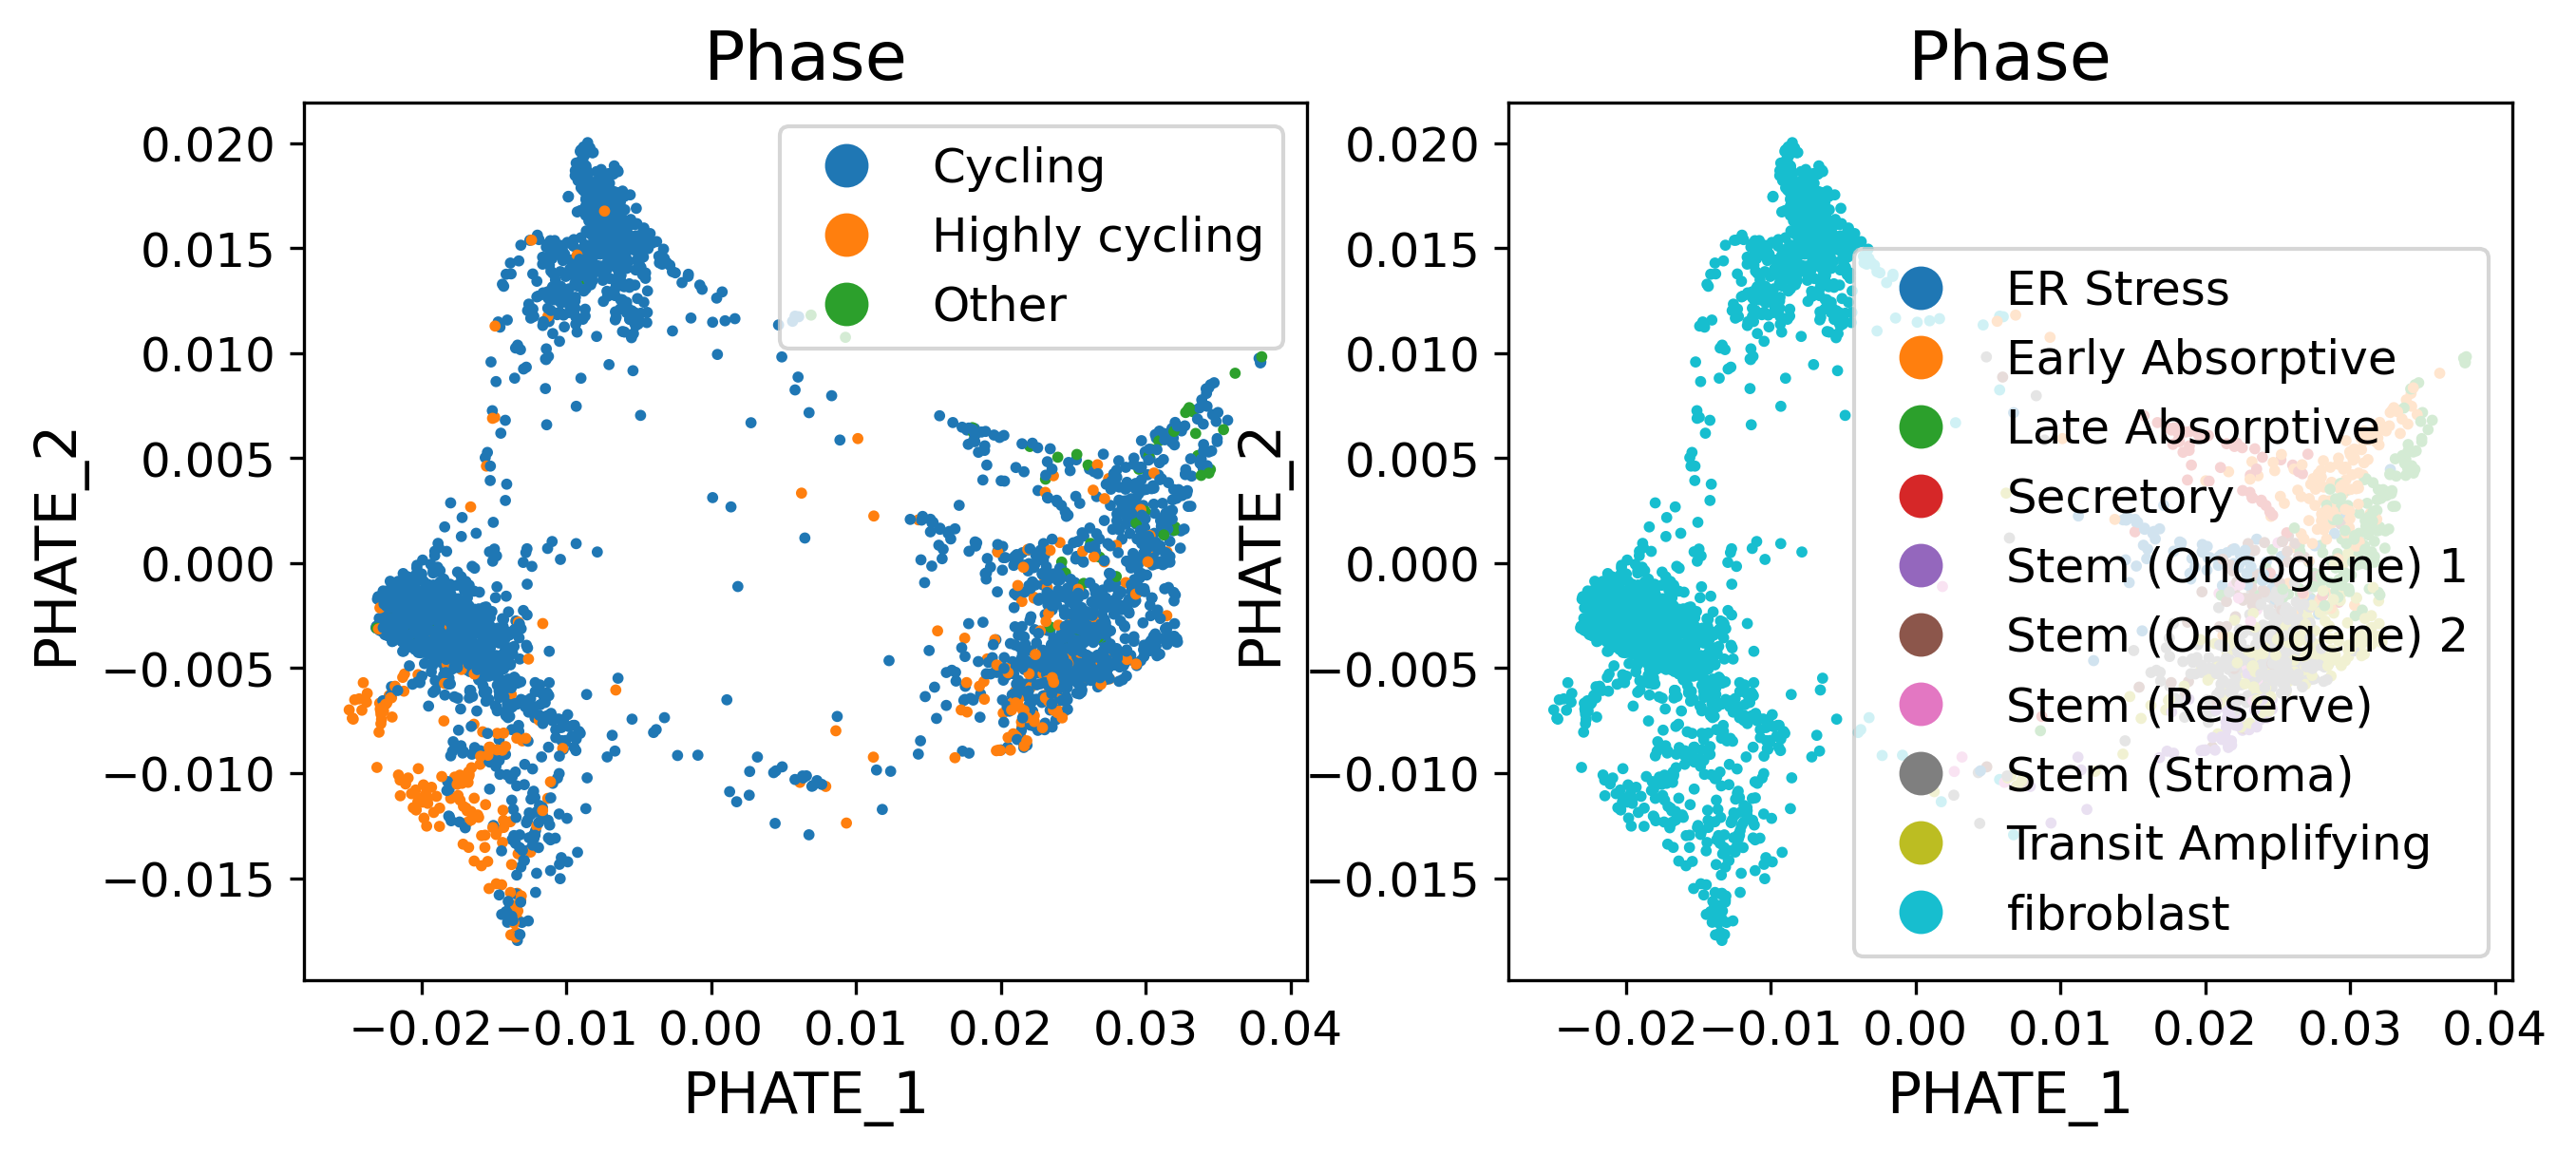

In [41]:
#Add phate dims and view
dRnaSeq.obsm["X_PHATE"] = dftest

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.Phase, figsize=(4.8,3),
                     title=f"Phase", ax=ax[0])
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.finalPOPS, figsize=(4.8,3),
                     title=f"Phase", ax=ax[1])

del dftest

## KG DataBases

The integrated database is the object ingested by pykeen's *TriplesFactory*.

Then, once the scRNAseq has been loaded in, we can also subset the genes in 
this dataframe to those present in the scRNA-seq count matrix.

In [11]:
dEdgeList = pd.read_csv(f"{data_dir}/dINT_simpl.tsv", sep="\t", header=None)[[0,2]]
print(dEdgeList.shape)

#Filter rows if either column not in list(dGenesSEQ)
dEdgeList = dEdgeList.loc[dEdgeList[0].isin(list(dGenesSeq)) & dEdgeList[2].isin(list(dGenesSeq))]
dEdgeList

(439023, 2)


,0,2
0,Tgfb1,Tgfbr1
1,Tgfb1,Tgfbr2
2,Tgfb2,Tgfbr1
3,Tgfb2,Tgfbr2
4,Tgfb3,Tgfbr1
...,...,...
438929,Paqr8,Efhc1
438930,Teddm3,Tmem198b
438931,Teddm3,Slc7a15
438943,Cys1,Fut2


## Process scRNA data

### Normalise and denoise gene expression data

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Then subset to genes present in KG.
Then normalise so that the gene expression distributions are equally big for each cell.

In [11]:
#MAGIC

In [12]:
gKG = dEdgeList.melt()["value"].drop_duplicates()
gKG

0          Tgfb1
2          Tgfb2
4          Tgfb3
12          Bmp2
17          Bmp4
           ...  
348019      Cipc
348023     Paqr8
348024    Teddm3
348026      Cys1
348512     Gpr19
Name: value, Length: 12229, dtype: object

# Approach 1-DEMD: Project cell data on gene graph

First we'll need to build and adjancency matrix from the KG. 
Then we will compute DEMD with the adjacency matrix and the distributions of 
normalised gene expression for each cell on our dataset.

## Adjacency matrix from KG

Using [networkx](https://networkx.org/documentation/stable/install.html) package.

From the integrated database, we've made a pandas dataframe that has only the 
source and target columns and then use that to make a NetworkX Graph object 
with `from_pandas_edgelist`

In [13]:
# #First make graph
# G = networkx.from_pandas_edgelist(dEdgeList, 0, 2)
# G

In [14]:
# #Adjacency matrix
# AdjMat = networkx.adjacency_matrix(G)
# AdjMat

## Compute Distances

# Approach 2-Wavelets

According to Smita should increase biological interpretability 
(big wavelets capture a biological process/feature)